In [1]:
import torch
import matplotlib.pyplot as plt
import pandas
import os
import torchvision
from torchvision.datasets import ImageFolder
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import random
from torchinfo import summary
from torchmetrics import Accuracy

In [2]:
data_dir = 'data/pizza_steak_sushi'
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()
])

In [4]:
train_images = ImageFolder(train_dir,transform=transform)
test_images = ImageFolder(test_dir, transform=transform)
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_images, batch_size=32)

In [5]:
num_classes = len(test_images.classes)

## Visualizing the patches 

In [6]:
image = next(iter(test_dataloader))[0][0].permute(1,2,0)

In [7]:
patch_size =16
num_patch = 224//16
img_size = 224

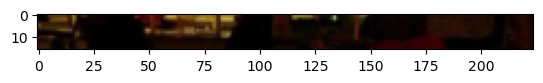

In [8]:
plt.imshow(image[:patch_size,:,:]) # image[y,x,step]

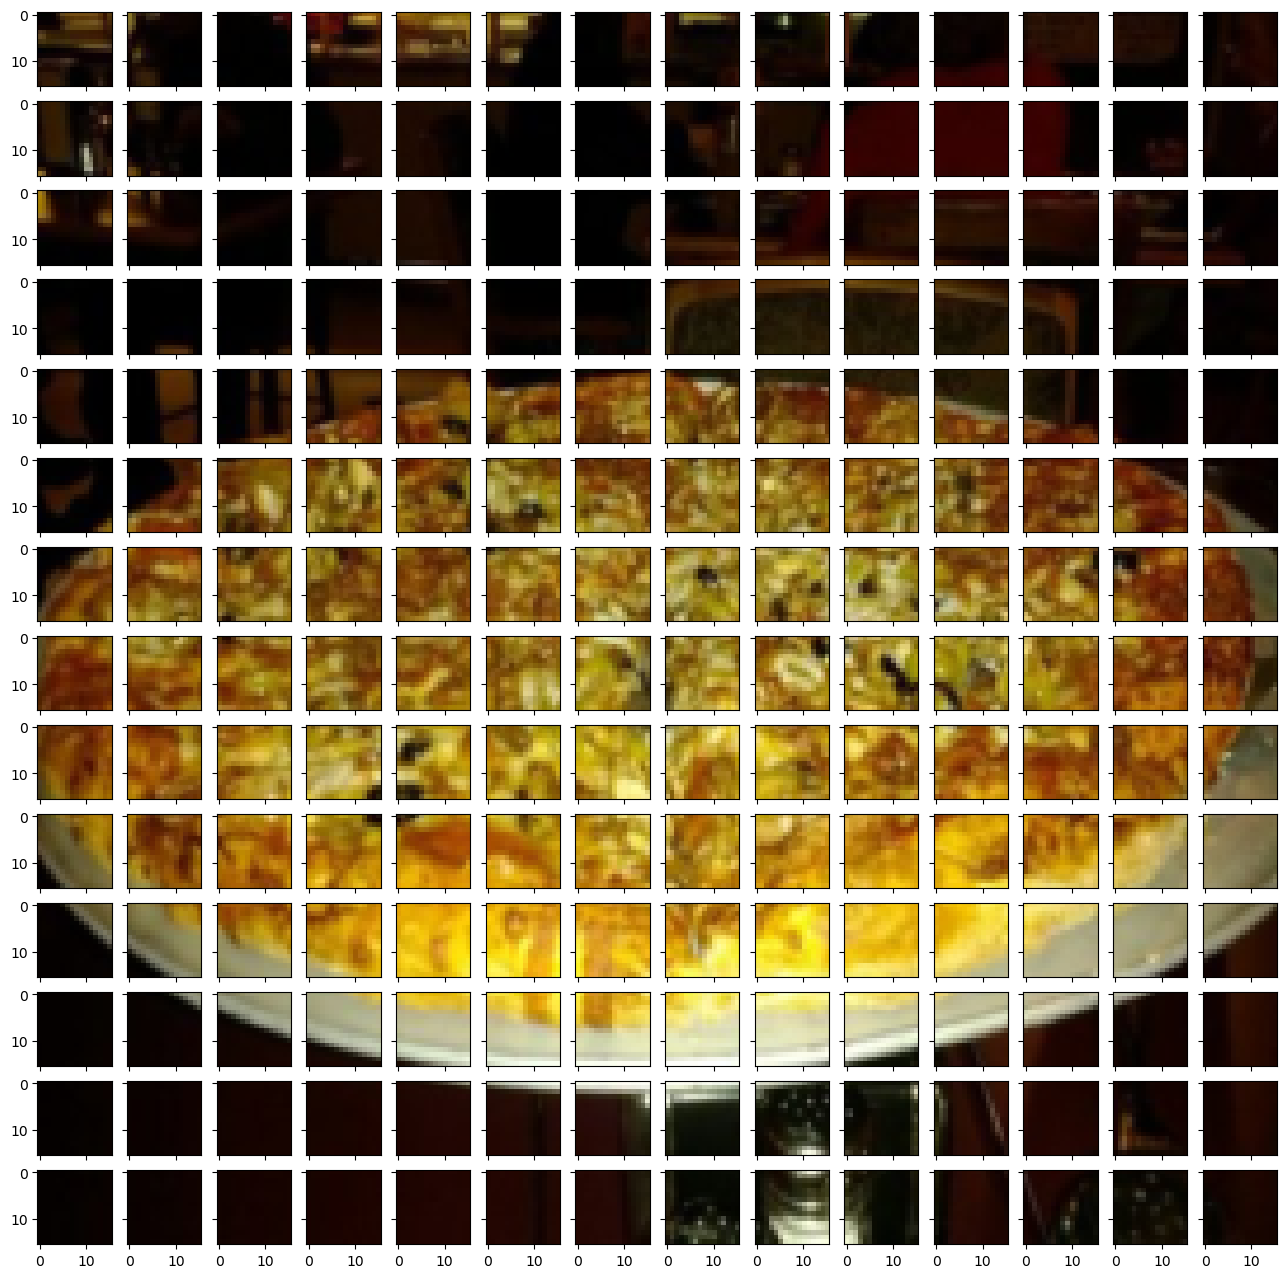

In [9]:
fig, ax = plt.subplots(nrows=num_patch, ncols=num_patch, sharex=True, sharey=True, figsize = (patch_size,patch_size))
for i, y_patch in enumerate(range(0, img_size, patch_size)):
    for j, x_patch in enumerate(range(0, img_size, patch_size)):
        ax[i,j].imshow(image[y_patch:y_patch+patch_size,x_patch:x_patch+patch_size,:])

## Vision transformer diagram

Original paper from An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale 

Source :https://arxiv.org/abs/2010.11929

![alt text](visiontransformer.png "Title")

![alt text](equation.png "Title")

![alt text](parameter_table.png "Title")

In [10]:
conv2d  = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size)

In [11]:
patched_image = conv2d(next(iter(test_dataloader))[0][0].unsqueeze(0))
patched_image.shape

torch.Size([1, 768, 14, 14])

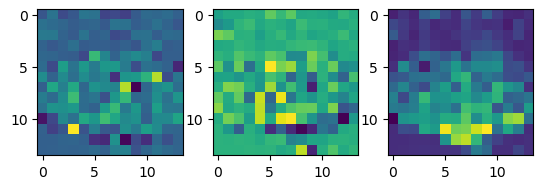

In [12]:
random_index = np.random.choice(range(0,768), 3)

fig, ax = plt.subplots(ncols=3, nrows=1)

for i,idx in enumerate(random_index):
    featuremap = patched_image[:,idx,:,:].squeeze().detach().numpy()
    ax[i].imshow(featuremap)

In [13]:
flatten_layer  = nn.Flatten(start_dim=2)

In [14]:
flatten_layer(patched_image).shape

torch.Size([1, 768, 196])

In [15]:
class patchembedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, out_channels:int=768):
        super().__init__()
        self.patch_flat = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=patch_size,stride=patch_size),
                                        nn.Flatten(start_dim=2))
        
    def forward(self,x):
        return self.patch_flat(x).permute(0,2,1)

In [16]:
model = patchembedding()

In [17]:
image = next(iter(train_dataloader))[0][0]

In [18]:
image.shape

torch.Size([3, 224, 224])

In [19]:
model(image.unsqueeze(0)).shape

torch.Size([1, 196, 768])

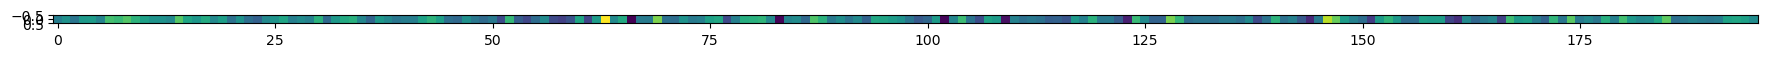

In [20]:
plt.figure(figsize=(22,22))
plt.imshow(model(image.unsqueeze(0)).detach().numpy()[:,:,7])

In [21]:
patched_embedded_image = model(image.unsqueeze(0))
batch_size = patched_embedded_image.shape[0]
dim_size = patched_embedded_image.shape[-1]
patch_dim_size = patched_embedded_image.shape[1]

In [22]:
class_token = nn.Parameter(torch.randn(batch_size,1,dim_size, requires_grad=True))

In [23]:
patched_embedded_withclass = torch.cat((class_token, patched_embedded_image), dim=1)

In [24]:
patched_embedded_withclass.shape

torch.Size([1, 197, 768])

In [25]:
positional_patched_embedded_image = patched_embedded_withclass + torch.randn((1,patch_dim_size+1,dim_size), requires_grad=True)

Equation 1 patching class learnable concat and positional embedding 

In [26]:
class patchembedding_with_positional_class(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, out_channels:int=768, device:str='cpu'):
        super().__init__()
        self.patch_flat = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=patch_size,stride=patch_size),
                                        nn.Flatten(start_dim=2))
        self.device = device
        
    def forward(self,x):
        patched_embedding =  self.patch_flat(x).permute(0,2,1)#change the shape to (batch, patch size, dim size)
        batch_size = patched_embedding.shape[0]
        dim_size = patched_embedding.shape[-1]
        patch_dim = patched_embedding.shape[1]
        patched_embedding_with_class = torch.cat((nn.Parameter(torch.randn(batch_size,1,dim_size, requires_grad=True)).to(self.device), patched_embedding.to(self.device)), dim=1)
        positional_encode = torch.randn(1, patch_dim+1, dim_size, requires_grad=True).to(self.device)
        patched_embedded_withclass_position = patched_embedding_with_class + positional_encode
        return patched_embedded_withclass_position

In [27]:
model = patchembedding_with_positional_class()

In [28]:
model(image.unsqueeze(0))

tensor([[[ 0.3293,  0.7196, -0.0747,  ..., -0.1832, -0.0327,  0.8524],
         [ 1.6096, -1.5973,  0.4919,  ..., -0.0106,  0.1683,  0.3945],
         [ 0.6721,  1.2201,  0.3519,  ...,  0.1902, -1.6727,  0.4166],
         ...,
         [ 0.5714,  1.0207, -0.3987,  ..., -1.9377,  1.3860,  1.7339],
         [ 1.7284,  0.9506, -0.5801,  ...,  0.5723, -0.4084, -0.2359],
         [-0.1250, -1.5574, -1.7142,  ..., -1.2085, -0.1824, -0.4026]]],
       grad_fn=<AddBackward0>)

Shape recap

patch size (sequence) of 1 for concating 

In [29]:
torch.randn((3,1,3))

tensor([[[-0.5053,  0.4961,  0.6585]],

        [[-2.2213, -0.8450,  0.6390]],

        [[-0.8431, -1.4573, -1.4484]]])

Batch of 1 for adding to the whole sequence 

In [30]:
torch.randn((1,3,3))

tensor([[[ 0.3154,  0.1753,  0.2784],
         [ 0.2981,  1.5730, -0.4180],
         [-0.6794, -0.3452,  0.3731]]])

## Transformer encoder

![alt text](transformer_encoder.png "Title")

Equation 2 MSA block

In [31]:
class multiheadattention(nn.Module):
    def __init__(self, emb_dim:int=768, num_head:int=12):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=emb_dim)
        self.multihead = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=num_head, batch_first=True)# batch_first since our data shape in ()

    def forward(self, x):
        x = self.layer_norm(x)
        x , _= self.multihead(query = x, key = x, value = x, need_weights = False)
        return x

Equation 3 MLP block

In [32]:
class MLP(nn.Module):
    def __init__(self, emb_dim:int=768, mlp_size:int=3072, dropout:int = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=emb_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=emb_dim,out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size, out_features=emb_dim),
                                 nn.Dropout(p=dropout))
    def forward(self, x ):
        return self.mlp(self.layer_norm(x))

Whole transformer encoder 

In [33]:
class transformer_encoder(nn.Module):
    def __init__(self, emb_dim:int=768, num_head:int=12, mlp_size:int=3072, dropout:int = 0.1):#for the hyperparameter values check paper table
        super().__init__()
        self.multihead = multiheadattention(emb_dim=emb_dim, num_head=num_head)
        self.mlp = MLP(emb_dim=emb_dim, mlp_size=mlp_size, dropout=dropout)
    
    def forward(self, x):#for more detail for the transformer encoder check the paper diagram
        x = self.multihead(x) + x
        x = self.mlp(x) + x
        return x

# Shape of transformer encoder input to output

In [34]:
transformer = transformer_encoder()

summary(transformer, input_size=(1,197,768), col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, row_settings=['var_names'])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
transformer_encoder (transformer_encoder)     [1, 197, 768]        [1, 197, 768]        --                   True
├─multiheadattention (multihead)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead)         --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

# Transformer layer provided by Pytorch

![alt text](transformerlayer.png "Title")

lets try replicating with transformer layer

In [35]:
transformerencoder = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation='gelu',norm_first=True, batch_first=True)
transformerencoder

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

# VIT transformer full form

In [36]:
class VIT(nn.Module):
    def __init__(self, emb_dim:int=768, mlp_size:int = 3072, dropout:int=0.1,patch_size:int=16,in_channel:int=3,num_head:int=12,num_transformer_layer:int=12,device:str='mps', num_classes:int=1000):
        super().__init__()
        self.patch_class_position = patchembedding_with_positional_class(in_channels=in_channel,patch_size=patch_size,out_channels=emb_dim,device=device)
        self.transformer_encoder = nn.Sequential(*[transformer_encoder(emb_dim=emb_dim, num_head=num_head,mlp_size=mlp_size,dropout=dropout) for _ in range(num_transformer_layer)])#stacking the transformer layer of num layer
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=emb_dim),
                                        nn.Linear(in_features=emb_dim, out_features=num_classes))
        self.dropout = nn.Dropout(p=0.1)
    def forward(self,x):
        x = self.patch_class_position(x)
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        return self.classifier(x[:,0])

In [37]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [38]:
VIT(num_classes=num_classes, device=device)

VIT(
  (patch_class_position): patchembedding_with_positional_class(
    (patch_flat): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
  )
  (transformer_encoder): Sequential(
    (0): transformer_encoder(
      (multihead): multiheadattention(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp): MLP(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): transformer_encoder

In [39]:
vit = VIT(num_classes=num_classes).to(device)
next(vit.parameters()).device

device(type='mps', index=0)

## VIT in action training and testing

creating loss, optimizer and training loop

In [40]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3,betas=(0.9,0.999),weight_decay=0.1)
acc_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [41]:
def train_loop(train_data, model, optimizer, acc_fn, loss_fn,device,epoch):
    y_pred_list = []
    y_list = []
    total_loss = 0
    model.train()
    for X,y in train_dataloader:
        X,y = X.to(device), y.to(device)
        y_logit = model(X)
        loss = loss_fn(y_logit, y)
        total_loss+=loss
        y_pred_list.append(y_logit)
        y_list.append(y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss/=len(y)
    acc = acc_fn(torch.cat(y_pred_list),torch.cat(y_list) )
    print(f'epoch {str(epoch)} train loss : {total_loss} train accuracy : {acc} ')

def test_loop(test_data, model, acc_fn, loss_fn, device, epoch):
    y_pred_list = []
    y_list = []
    total_loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_data:
            X,y = X.to(device), y.to(device)
            y_logit = model(X)
            loss = loss_fn(y_logit,y)
            y_pred_list.append(y_logit)
            y_list.append(y)
            total_loss+=loss
        total_loss/=len(y)
        acc = acc_fn(torch.cat(y_pred_list),torch.cat(y_list))
        print(f'epoch {str(epoch)} test loss : {total_loss} test accuracy : {acc} ')

Training and testing 

In [42]:
epoch = 5
for i in range(epoch):
    train_loop(train_data=train_dataloader, model=vit, optimizer=optimizer, acc_fn=acc_fn, loss_fn=loss_fn,device=device,epoch=i+1)
    test_loop(test_data=test_dataloader,model=vit,acc_fn=acc_fn,loss_fn=loss_fn,device=device,epoch=i+1)

epoch 1 train loss : 29.197059631347656 train accuracy : 0.3466666638851166 
epoch 1 test loss : 0.47038519382476807 test accuracy : 0.41333332657814026 
epoch 2 train loss : 11.556171417236328 train accuracy : 0.31111112236976624 
epoch 2 test loss : 0.5063404440879822 test accuracy : 0.41333332657814026 
epoch 3 train loss : 15.016768455505371 train accuracy : 0.3422222137451172 
epoch 3 test loss : 0.739757776260376 test accuracy : 0.25333333015441895 
epoch 4 train loss : 12.128618240356445 train accuracy : 0.30222222208976746 
epoch 4 test loss : 0.3898526132106781 test accuracy : 0.25333333015441895 
epoch 5 train loss : 9.830442428588867 train accuracy : 0.3377777636051178 
epoch 5 test loss : 0.27322226762771606 test accuracy : 0.5199999809265137 


## VIT transformer from Torchvision pretrain

In [43]:
vit_pretrain_weight = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_pretrain_model = torchvision.models.vit_b_16(weights=vit_pretrain_weight).to(device)
vit_transform = vit_pretrain_weight.transforms()

In [44]:
for param in vit_pretrain_model.parameters():
    param.requires_grad = False

In [45]:
vit_pretrain_model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=3, bias=True)).to(device)

In [46]:
vit_pretrain_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [47]:
train_images = ImageFolder(train_dir,transform=vit_transform)
test_images = ImageFolder(test_dir, transform=vit_transform)
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_images, batch_size=32)

In [48]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=vit_pretrain_model.parameters(), lr=1e-3,betas=(0.9,0.999),weight_decay=0.1)
acc_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [49]:
epoch = 5
for i in range(epoch):
    train_loop(train_data=train_dataloader, model=vit_pretrain_model, optimizer=optimizer, acc_fn=acc_fn, loss_fn=loss_fn,device=device,epoch=i+1)
    test_loop(test_data=test_dataloader,model=vit_pretrain_model,acc_fn=acc_fn,loss_fn=loss_fn,device=device,epoch=i+1)

epoch 1 train loss : 7.772336006164551 train accuracy : 0.5111111402511597 
epoch 1 test loss : 0.15019230544567108 test accuracy : 0.9466666579246521 
epoch 2 train loss : 3.3008251190185547 train accuracy : 0.9155555367469788 
epoch 2 test loss : 0.08000749349594116 test accuracy : 0.9333333373069763 
epoch 3 train loss : 2.0582025051116943 train accuracy : 0.9422222375869751 
epoch 3 test loss : 0.06773536652326584 test accuracy : 0.9466666579246521 
epoch 4 train loss : 1.7399312257766724 train accuracy : 0.9511111378669739 
epoch 4 test loss : 0.06141439452767372 test accuracy : 0.9466666579246521 
epoch 5 train loss : 1.2808558940887451 train accuracy : 0.9555555582046509 
epoch 5 test loss : 0.059454526752233505 test accuracy : 0.9466666579246521 
